<a href="https://colab.research.google.com/github/Rohan20202/Face-Emotion-Recognition/blob/main/Face_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Importing the required Libraries**

In [ ]:
import os                                                             # provides functions for creating and removing a directory
import numpy as np                                                    #For some math operations in predictions
import pandas as pd                                                   #Extensively used to load and wrangle with the dataset.
import tensorflow as tf
from matplotlib import pyplot                                         #Used for visualization.
import matplotlib.pyplot as plt  
from keras.losses import categorical_crossentropy          

## **Connecting to the drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## **Loading the dataset**

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Face Emotion Recognition - Rohan Jgadale/fer2013.csv')

In [ ]:
#first 5 rows of data
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
#shape and of the dataset
df.shape

(35887, 3)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [ ]:
# Total number of Emotion 
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [ ]:
#Assigning Names to Emotions in labels
emotion_dict = {0: 'anger', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'sad',5: 'suprise', 6: 'neutral'}
width = 48
height = 48
classes=np.array(("Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"))
df.Usage.value_counts() 

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

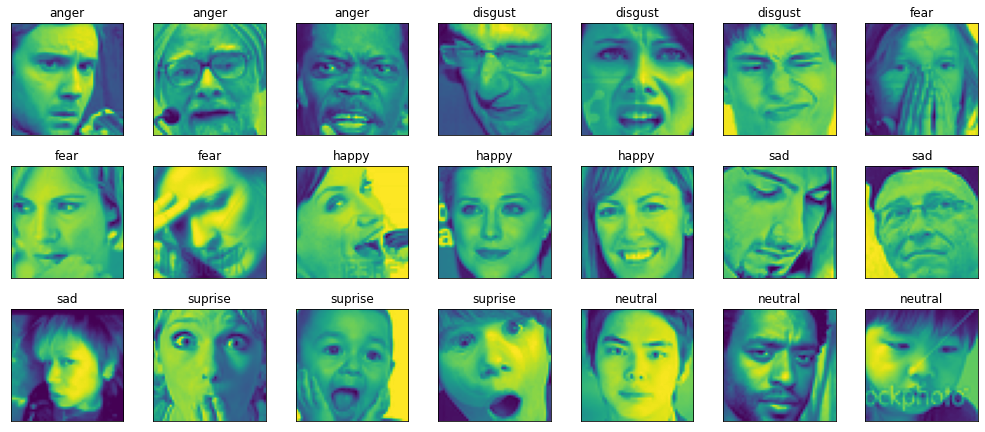

In [ ]:
fig = pyplot.figure(1, (14, 14))
k = 0
for label in sorted(df.emotion.unique()):
    for j in range(3):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_dict[label])
        pyplot.tight_layout()

In [ ]:
k = np.array(list(map(int,df.iloc[0,1].split(" "))),dtype='uint8').reshape((48,48))
k.shape

(48, 48)

In [ ]:
X_train = []
y_train = []
X_test = []
y_test = []
for index, row in df.iterrows():
    k = row['pixels'].split(" ")
    if row['Usage'] == 'Training':
        X_train.append(np.array(k))
        y_train.append(row['emotion'])
    elif row['Usage'] == 'PublicTest':
        X_test.append(np.array(k))
        y_test.append(row['emotion'])

In [ ]:
X_train[0]

array(['70', '80', '82', ..., '106', '109', '82'], dtype='<U3')

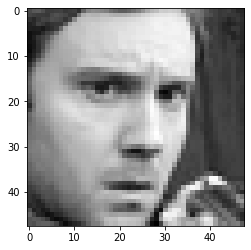

In [ ]:
pyplot.imshow(np.array(X_train[0], dtype = 'uint8').reshape(48,48), cmap = 'gray')

### **Train and Test data sets**

In [ ]:
X_train = np.array(X_train, dtype = 'uint8')
y_train = np.array(y_train, dtype = 'uint8')
X_test = np.array(X_test, dtype = 'uint8')
y_test = np.array(y_test, dtype = 'uint8')

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

In [ ]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((28709, 48, 48, 1), (28709,), (3589, 48, 48, 1), (3589,))

In [ ]:
from keras.utils.np_utils import to_categorical
y_train= to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

## **Image Augmentation**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator 
datagen = ImageDataGenerator( 
    rescale=1./255,
    rotation_range = 10,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode = 'nearest')

testgen = ImageDataGenerator( 
    rescale=1./255
    )
datagen.fit(X_train)
batch_size = 64

In [ ]:
train_flow = datagen.flow(X_train, y_train, batch_size=batch_size) 
test_flow = testgen.flow(X_test, y_test, batch_size=batch_size)

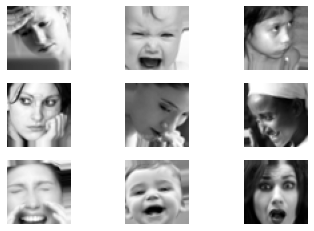

In [ ]:
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    for i in range(0, 9): 
        plt.axis('off') 
        plt.subplot(330 + 1 + i) 
        plt.imshow(X_batch[i].reshape(48, 48), cmap=plt.get_cmap('gray'))
    plt.axis('off') 
    plt.show() 
    break

# **Creating model for training**

### **Required libraries for Model Implementation**

In [ ]:
from keras.layers import Convolution2D,MaxPooling2D,Flatten,Dense
from keras.models import Sequential

In [ ]:
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from tensorflow.keras.optimizers import Adam , RMSprop ,SGD                     #for training deep learning models
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

## **Model Implemented**

In [ ]:
def FER_Model(input_shape=(48,48,1)):
    # first input model
    visible = Input(shape=input_shape, name='input')

    #the 1-st block
    conv1_1 = Conv2D(32, kernel_size=3, strides=(1,1),activation='relu', name = 'conv1_1')(visible)
    pool1_1 = MaxPooling2D(pool_size=(2,2), name = 'pool1_1')(conv1_1)
    conv1_1 = BatchNormalization()(pool1_1)

    #the 2-nd block
    conv2_1 = Conv2D(64, kernel_size=3, strides=(1,1),activation='relu',name = 'conv2_1')(conv1_1)
    pool2_1 = MaxPooling2D(pool_size=(2,2), name = 'pool2_1')(conv2_1)
    conv2_1 = BatchNormalization()(pool2_1)

    #the 3-rd block
    conv3_1 = Conv2D(128, kernel_size=3,strides=(1,1), activation='relu', name = 'conv3_1')(pool2_1)
    pool3_1 = MaxPooling2D(pool_size=(2,2), name = 'pool3_1')(conv3_1)
    conv3_1 = BatchNormalization()(pool3_1)

    #Flatten and output
    flatten = Flatten(name = 'flatten')(conv3_1)
    drop1 = Dense(480, activation='relu', name = 'drop1')(flatten)
    drop2 = Dense(240, activation='relu', name = 'drop2')(drop1)
    ouput = Dense(7, activation='softmax', name = 'output')(drop2)

    # create model 
    model = Model(inputs =visible, outputs = ouput)
    
    # summary layers
    print(model.summary())
    
    return model

In [ ]:
model = FER_Model()
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 48, 1)]       0         
                                                                 
 conv1_1 (Conv2D)            (None, 46, 46, 32)        320       
                                                                 
 pool1_1 (MaxPooling2D)      (None, 23, 23, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 23, 23, 32)       128       
 ormalization)                                                   
                                                                 
 conv2_1 (Conv2D)            (None, 21, 21, 64)        18496     
                                                                 
 pool2_1 (MaxPooling2D)      (None, 10, 10, 64)        0         
                                                             

In [ ]:
from keras.callbacks import ModelCheckpoint
filepath="weights_min_loss.hdf5"
checkpoint = ModelCheckpoint(filepath,monitor= 'val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
num_epochs = 100
history = model.fit(train_flow, 
                    steps_per_epoch=len(X_train) / batch_size, 
                    epochs=num_epochs,
                    verbose=1,  
                    callbacks=callbacks_list,
                    validation_data=test_flow,  
                    validation_steps=len(X_test) / batch_size)

Epoch 1/100
449/448 [==============================] - ETA: 0s - loss: 1.6254 - accuracy: 0.3617
Epoch 00001: val_loss improved from inf to 1.64759, saving model to weights_min_loss.hdf5
448/448 [==============================] - 119s 265ms/step - loss: 1.6254 - accuracy: 0.3617 - val_loss: 1.6476 - val_accuracy: 0.3383
Epoch 2/100
449/448 [==============================] - ETA: 0s - loss: 1.3753 - accuracy: 0.4683
Epoch 00002: val_loss improved from 1.64759 to 1.56639, saving model to weights_min_loss.hdf5
448/448 [==============================] - 119s 265ms/step - loss: 1.3753 - accuracy: 0.4683 - val_loss: 1.5664 - val_accuracy: 0.4283
Epoch 3/100
449/448 [==============================] - ETA: 0s - loss: 1.2758 - accuracy: 0.5104
Epoch 00003: val_loss improved from 1.56639 to 1.28052, saving model to weights_min_loss.hdf5
448/448 [==============================] - 117s 262ms/step - loss: 1.2758 - accuracy: 0.5104 - val_loss: 1.2805 - val_accuracy: 0.5110
Epoch 4/100
449/448 [=====

# **Testing Model**

<Figure size 432x288 with 0 Axes>

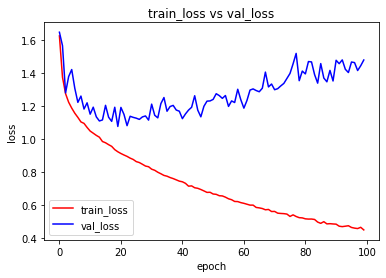

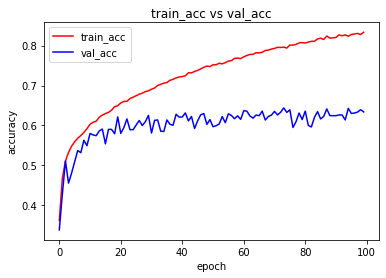

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline

train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.figure()

In [ ]:
model.save('../working/Fer2013.h5')

In [ ]:
loss = model.evaluate(X_test/255., y_test) 
print("Test Loss " + str(loss[0]))
print("Test Acc: " + str(loss[1]))

113/113 [==============================] - 4s 35ms/step - loss: 1.4796 - accuracy: 0.6339
Test Loss 1.4795806407928467
Test Acc: 0.6338813304901123


113/113 [==============================] - 4s 34ms/step


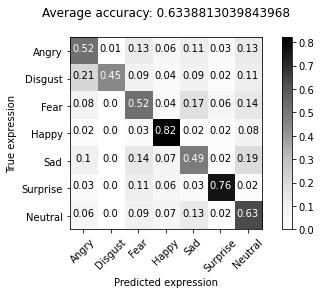

In [ ]:
import itertools 
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Unnormalized confusion matrix',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_test, y_pred)
    
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        
    np.set_printoptions(precision=2)
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True expression')
    plt.xlabel('Predicted expression')
    plt.show()
y_pred_ = model.predict(X_test/255., verbose=1)
y_pred = np.argmax(y_pred_, axis=1)
t_te = np.argmax(y_test, axis=1)
fig = plot_confusion_matrix(y_test=t_te, y_pred=y_pred,
                      classes=classes,
                      normalize=True,
                      cmap=plt.cm.Greys,   title='Average accuracy: ' + str(np.sum(y_pred == t_te)/len(t_te)) + '\n')

In [ ]:
from keras.models import Model, model_from_json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
